# 05 — Grouped PV-Tendency Terms & Bootstrap Significance

This notebook demonstrates:

1. Loading **all** blocking-event NPZ files for a given (stage, dh)
2. Grouping PV-tendency cross-terms into physically meaningful categories
3. Projecting each group onto the four-basis decomposition
4. Bootstrap resampling for confidence intervals and significance testing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from concurrent.futures import ThreadPoolExecutor

from pvtend import compute_orthogonal_basis, project_field
from pvtend.decomposition.smoothing import gaussian_smooth_nan
from pvtend.decomposition.basis import PRENORM_PHI1

## 1  Discover and load all event files

In [2]:
DATA_ROOT = "/net/flood/data2/users/x_yan/tempest_extreme_4_basis/outputs_tmp"
STAGE = "onset"
DH = 0

sign = "+" if DH >= 0 else ""
npz_dir = f"{DATA_ROOT}/blocking_tmp/{STAGE}/dh={sign}{DH}"
npz_files = sorted(glob.glob(os.path.join(npz_dir, "track_*.npz")))
print(f"Found {len(npz_files)} events for stage={STAGE}, dh={DH}")

Found 348 events for stage=onset, dh=0


In [3]:
def load_event(path):
    """Load an NPZ file and return a dict."""
    return dict(np.load(path))

# Load all events (parallel I/O)
with ThreadPoolExecutor(max_workers=8) as pool:
    events = list(pool.map(load_event, npz_files))

print(f"Loaded {len(events)} events, each with {len(events[0])} fields")
X_rel = events[0]["X_rel"]
Y_rel = events[0]["Y_rel"]
x_rel = X_rel[0, :]
y_rel = Y_rel[:, 0]

Loaded 348 events, each with 172 fields


## 2  Compute composite-mean basis fields

In [4]:
# Average PV anomaly and its derivatives across all events
pv_anom_mean = np.mean([e["pv_anom"] for e in events], axis=0)
pv_dx_mean   = np.mean([e["pv_anom_dx"] for e in events], axis=0)
pv_dy_mean   = np.mean([e["pv_anom_dy"] for e in events], axis=0)

basis = compute_orthogonal_basis(
    pv_anom_mean, pv_dx_mean, pv_dy_mean,
    x_rel, y_rel,
    mask_negative=True,
    apply_smoothing=True, smoothing_deg=6.0, grid_spacing=1.5,
)
print("Composite basis norms:", {k: f"{v:.4e}" for k, v in basis.norms.items()})

Composite basis norms: {'beta': '5.8484e+02', 'ax': '8.9081e+02', 'ay': '7.1624e+02', 'gamma': '4.4949e+02'}


## 3  Define grouped terms

In [5]:
# Physical groupings of PV-tendency cross-terms
GROUPS = {
    "leading_order_adv": [
        "u_bar_pv_anom_dx", "v_bar_pv_anom_dy",
        "u_anom_pv_bar_dx", "v_anom_pv_bar_dy",
    ],
    "eddy_total": [
        "u_rot_pv_anom_dx", "v_rot_pv_anom_dy",
        "u_div_pv_anom_dx", "v_div_pv_anom_dy",
        "u_har_pv_anom_dx", "v_har_pv_anom_dy",
        "u_anom_pv_anom_dx", "v_anom_pv_anom_dy",  # for 2D checks
    ],
    "moist_indirect": [
        "u_div_moist_pv_anom_dx", "v_div_moist_pv_anom_dy",
        "w_anom_pv_anom_dp",
    ],
    "Q": ["Q"],
}

def sum_group(event, group_terms, negate_advection=True):
    """Sum a group of terms from an event, with sign convention -u·∇q."""
    total = np.zeros_like(event["pv_anom"])
    for t in group_terms:
        if t in event:
            val = event[t]
            if negate_advection and t != "Q":
                val = -val
            total += val
    return total

## 4  Project composite-mean grouped terms

In [6]:
# Compute composite mean of each group
group_means = {}
for gname, terms in GROUPS.items():
    group_means[gname] = np.mean(
        [sum_group(e, terms) for e in events], axis=0
    )

# Project each group
group_coefs = {}
for gname, field in group_means.items():
    field_s = gaussian_smooth_nan(field, smoothing_deg=6.0, grid_spacing=1.5)
    p = project_field(field_s, basis)
    group_coefs[gname] = {k: p[k] for k in ["beta", "ax", "ay", "gamma"]}
    print(f"{gname:25s}  β={p['beta']:.3e}  αx={p['ax']:.3f}  "
          f"αy={p['ay']:.3f}  γ={p['gamma']:.3e}")

leading_order_adv          β=1.070e-06  αx=9.410  αy=-0.270  γ=-7.157e+05
eddy_total                 β=6.956e-06  αx=0.691  αy=3.954  γ=6.562e+05
moist_indirect             β=-1.064e-06  αx=-0.144  αy=-0.766  γ=-7.802e+05
Q                          β=-5.952e-07  αx=-0.440  αy=-0.058  γ=3.441e+04


## 5  Bootstrap resampling for significance

In [7]:
N_BOOT = 1000
rng = np.random.default_rng(42)
n_events = len(events)

def bootstrap_group(group_name, terms, n_boot=N_BOOT):
    """Bootstrap the projected coefficients for one group."""
    # Per-event projections
    per_event = []
    for e in events:
        field = sum_group(e, terms)
        field_s = gaussian_smooth_nan(field, smoothing_deg=6.0, grid_spacing=1.5)
        p = project_field(field_s, basis)
        per_event.append({k: p[k] for k in ["beta", "ax", "ay", "gamma"]})

    per_event_arr = {k: np.array([pe[k] for pe in per_event]) for k in ["beta", "ax", "ay", "gamma"]}

    # Bootstrap
    boot = {k: np.empty(n_boot) for k in ["beta", "ax", "ay", "gamma"]}
    for b in range(n_boot):
        idx = rng.integers(0, n_events, size=n_events)
        for k in boot:
            boot[k][b] = per_event_arr[k][idx].mean()

    return boot

print("Running bootstrap (this may take a minute)...")
boot_results = {}
for gname, terms in GROUPS.items():
    boot_results[gname] = bootstrap_group(gname, terms)
    lo, hi = np.percentile(boot_results[gname]["beta"], [2.5, 97.5])
    sig = "***" if lo * hi > 0 else "n.s."
    print(f"  {gname:25s}  β 95% CI: [{lo:.3e}, {hi:.3e}]  {sig}")

Running bootstrap (this may take a minute)...
  leading_order_adv          β 95% CI: [4.964e-07, 1.677e-06]  ***


  eddy_total                 β 95% CI: [6.156e-06, 7.904e-06]  ***


  moist_indirect             β 95% CI: [-1.315e-06, -8.342e-07]  ***


  Q                          β 95% CI: [-7.409e-07, -4.500e-07]  ***


## 6  Visualise bootstrap results

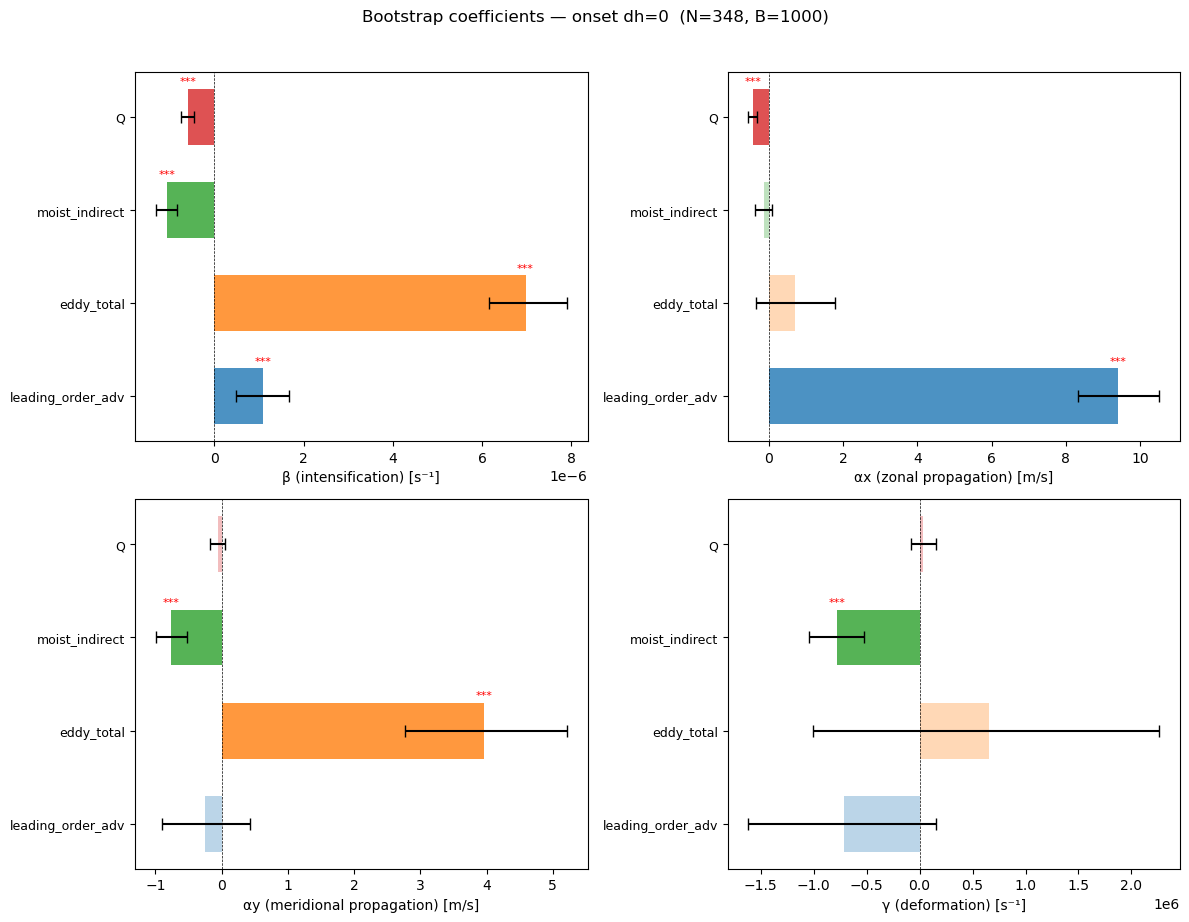

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
coef_names = ["beta", "ax", "ay", "gamma"]
coef_labels = ["β (intensification) [s⁻¹]",
               "αx (zonal propagation) [m/s]",
               "αy (meridional propagation) [m/s]",
               "γ (deformation) [s⁻¹]"]
group_colors = {"leading_order_adv": "C0", "eddy_total": "C1",
                "moist_indirect": "C2", "Q": "C3"}

for ax, cname, clabel in zip(axes.flat, coef_names, coef_labels):
    for i, (gname, bdata) in enumerate(boot_results.items()):
        vals = bdata[cname]
        mean = vals.mean()
        lo, hi = np.percentile(vals, [2.5, 97.5])
        sig = lo * hi > 0  # does CI exclude zero?

        ax.barh(i, mean, xerr=[[mean - lo], [hi - mean]],
                color=group_colors.get(gname, "gray"),
                alpha=0.8 if sig else 0.3,
                capsize=4, height=0.6,
                label=gname if ax == axes.flat[0] else "")
        if sig:
            ax.text(mean, i + 0.35, "***", ha="center", fontsize=8, color="red")

    ax.set_yticks(range(len(GROUPS)))
    ax.set_yticklabels(list(GROUPS.keys()), fontsize=9)
    ax.axvline(0, color="k", lw=0.5, ls="--")
    ax.set_xlabel(clabel)

fig.suptitle(f"Bootstrap coefficients — {STAGE} dh={DH}  (N={n_events}, B={N_BOOT})", y=1.02)
fig.tight_layout()
plt.show()

## Summary

- PV-tendency cross-terms are **grouped** into physically meaningful categories:
  leading-order advection, eddy (rotational + divergent), moist-indirect, and diabatic Q.
- Each group is projected onto the same orthogonal basis to obtain (β, αx, αy, γ).
- **Bootstrap resampling** (N=1000) provides 95 % confidence intervals;
  bars are opaque when the CI excludes zero (significant at p < 0.05).